# Integrating geographical variables

In [ ]:
df_client = pd.concat([cons1, cons2, cons3, cons4, cons5, cons6])
df_client.loc[df_client['Quantity']<0,'Quantity'] = - df_client.loc[df_client['Quantity']<0,'Quantity']

In [ ]:
df_client= df_client.groupby(['Posting date', "Ship-To Party"], as_index = False).sum()
len(df_client['Ship-To Party'].unique())
df_printer_sales = pd.read_csv("Data/Printer_sales.csv", sep=',', parse_dates = [1])
print(f"Number of client in consumable df : {len(df_client['Ship-To Party'].unique())}")
print(f"Number of client in printer_sales df : {len(df_printer_sales['Ship-to'].unique())}")
print(f"Number of sector in printer_sales df : {len(df_printer_sales['Sector_code'].unique())}")
print(f"Number of country in printer_sales df : {len(df_printer_sales['Country_Code'].unique())}")
print(f"Number of country zone in printer_sales df : {len(df_printer_sales['Country_Zon'].unique())}")

# On enlève les strings des code (de secteur, et de pays)
df_printer_sales['Sector_code'] = df_printer_sales['Sector_code'].apply(lambda x : int(x.split('_')[1]))
df_printer_sales['Country_Code'] = df_printer_sales['Country_Code'].apply(lambda x : int(x.split('_')[1]))
df_printer_sales['Country_Zon'] = df_printer_sales['Country_Zon'].apply(lambda x : int(x.split('_')[1]))

# Create a df with geographical data of clients
df_client2 = df_client.copy().rename(columns = {'Ship-To Party' : 'Ship-to'})
df_printer_sales2 = df_printer_sales[['Ship-to', 'Sector_code', 'Country_Code', 'Country_Zon']].drop_duplicates()
df_client_geo = df_client2.join(df_printer_sales2.set_index('Ship-to'), on = 'Ship-to' , how = 'left')
df_client_geo.head(5)

Number of client in consumable df : 8663
Number of client in printer_sales df : 8663
Number of sector in printer_sales df : 17
Number of country in printer_sales df : 26
Number of country zone in printer_sales df : 9


,Posting date,Ship-to,4.Nature,Quantity,Sector_code,Country_Code,Country_Zon
0,2017-01-02,10032,CONSUMABLE,2,16,12,4
1,2017-01-02,13003,CONSUMABLE,2,6,12,4
2,2017-01-02,19383,CONSUMABLE,2,5,9,3
3,2017-01-02,27787,CONSUMABLE,11,6,12,4
4,2017-01-02,31710,CONSUMABLE,3,3,24,8


#### Basic stats and vizualisation on geographical data

In [ ]:
unique_sector = df_client_geo['Sector_code'].unique()
nb_sector = len(unique_sector)
unique_country = df_client_geo['Country_Code'].unique()
nb_country = len(unique_country)
unique_zone = df_client_geo['Country_Zon'].unique()
nb_zone = len(unique_zone)

print(f"Number of geographical sector : {nb_sector}")
print(f"Number of country : {nb_country}")
print(f"Number of zone : {nb_zone}")

Number of geographical sector : 17
Number of country : 26
Number of zone : 9


In [ ]:
df_client_geo['Posting date'] = pd.to_datetime(df_client_geo['Posting date'])
date_range = pd.date_range(start=df_client_geo['Posting date'].min(), end=df_client_geo['Posting date'].max(), freq='ME')

In [ ]:
sales_by_zone= df_client_geo.groupby([pd.Grouper(key='Posting date', freq='ME'), 'Country_Zon']).sum('Quantity')['Quantity'].reset_index()
sales_by_country= df_client_geo.groupby([pd.Grouper(key='Posting date', freq='ME'), 'Country_Code']).sum('Quantity')['Quantity'].reset_index()
sales_by_sector= df_client_geo.groupby([pd.Grouper(key='Posting date', freq='ME'), 'Sector_code']).sum('Quantity')['Quantity'].reset_index()

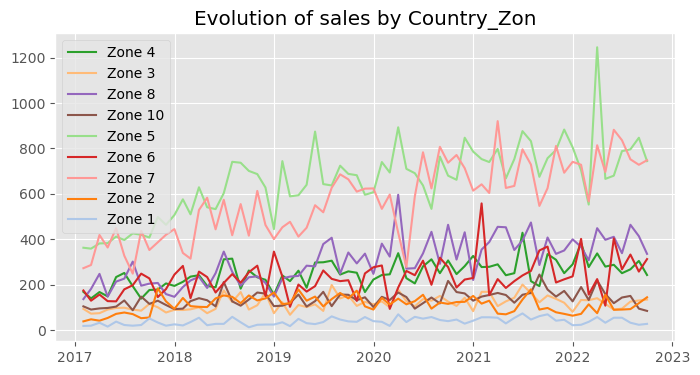

In [ ]:
def viz_sales_by_geo(sales_by, unique_type, geo, date_range, nb_line = 3):
    """
    
    """
    fig,ax = plt.subplots(figsize = (8,4))
    for zone in unique_type[:nb_line]:
        to_plot = sales_by_zone.loc[sales_by[geo]==zone,:].set_index('Posting date').reindex(date_range, fill_value=0)
        ax.plot(to_plot.index, to_plot['Quantity'], label = f'Zone {zone}', color = plt.cm.tab20(zone))
    ax.set_title("Evolution of sales by "+ geo)
    plt.legend()
    # plt.savefig(f'fig/{title}.png')
    plt.show()

viz_sales_by_geo(sales_by_zone, unique_zone, 'Country_Zon', date_range,9)

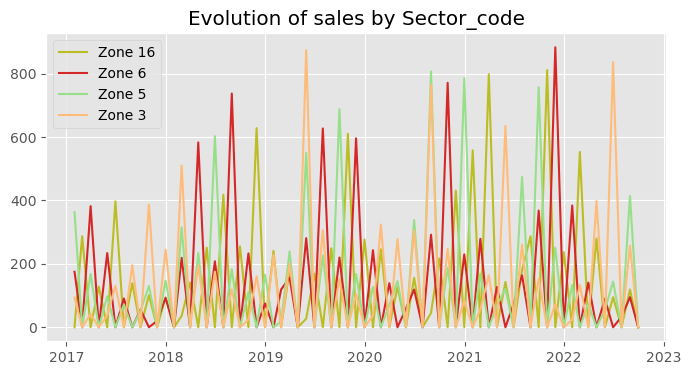

In [ ]:
viz_sales_by_geo(sales_by_sector, unique_sector, 'Sector_code', date_range, 4)

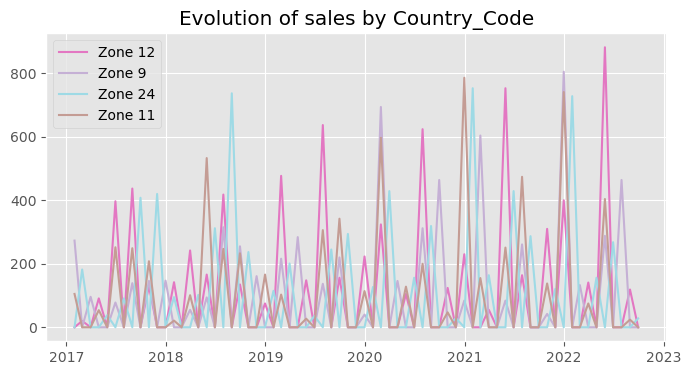

In [ ]:
viz_sales_by_geo(sales_by_country, unique_country, 'Country_Code', date_range, 4)

Prediction of some sector or country using croston method

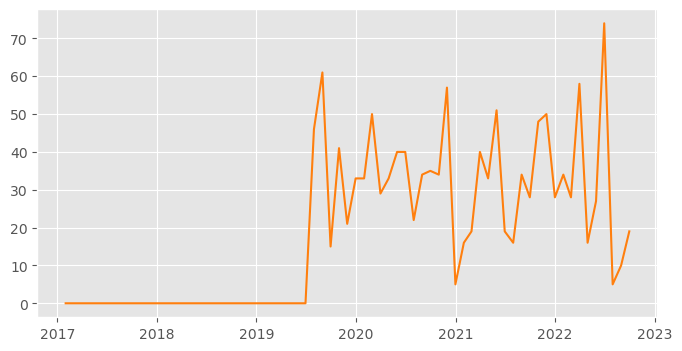

In [ ]:
fig,ax = plt.subplots(figsize = (8,4))
to_plot = sales_by_country.loc[sales_by_country['Country_Code']==21,:].set_index('Posting date').reindex(date_range, fill_value=0)
ax.plot(to_plot.index, to_plot['Quantity'], label = f'Zone {2}', color = plt.cm.tab20(2))

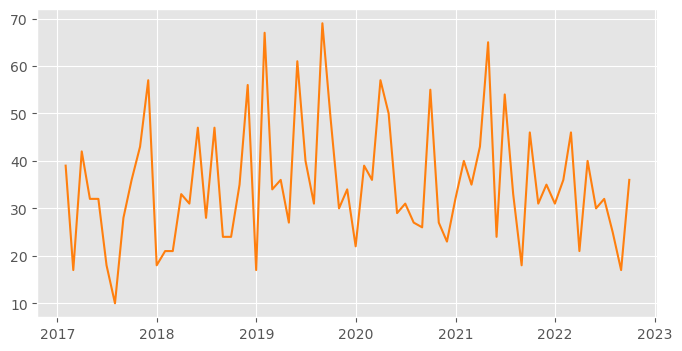

In [ ]:
fig,ax = plt.subplots(figsize = (8,4))
to_plot = sales_by_sector.loc[sales_by_sector['Sector_code']==7,:].set_index('Posting date').reindex(date_range, fill_value=0)
ax.plot(to_plot.index, to_plot['Quantity'], label = f'Zone {2}', color = plt.cm.tab20(2))

In [ ]:
def croston(ts, alpha=0.1):
    """
    Croston's method for intermittent demand forecasting.

    Parameters:
    ts (array-like): Time series data with intermittent demand.
    alpha (float): Smoothing parameter for the demand size and interval (default is 0.1).

    Returns:
    forecast (float): Forecasted demand.
    """
    # Initialize
    d = np.array(ts)
    non_zero_demand = d[d > 0]

    # Calculate the demand size and interval
    q = np.zeros_like(d, dtype=float)
    p = np.zeros_like(d, dtype=float)""

    # Initial values
    q[0] = non_zero_demand[0] if len(non_zero_demand) > 0 else 0
    p[0] = 1 if len(non_zero_demand) > 0 else np.inf

    # Croston's method
    for i in range(1, len(d)):
        if d[i] > 0:
            q[i] = alpha * d[i] + (1 - alpha) * q[i-1]
            p[i] = alpha * (i - p[i-1]) + (1 - alpha) * p[i-1]
        else:
            q[i] = q[i-1]
            p[i] = p[i-1]

    # Forecast
    forecast = q[-1] / p[-1]
    return forecast

#### Croston model
https://juileetalele.medium.com/croston-model-forecasting-intermittent-demand-data-time-series-analysis-6f3a2bb1654b

Croston model would be relievant if some month had a value fixed to 0.